In [1]:
#To filter the warnings
import warnings
warnings.filterwarnings('ignore')

For product categorization task, the conventional methods are based on machine learning classification algorithms, but this paper : ("Don’t Classify, Translate: Multi-Level E-Commerce Product Categorization Via Machine Translation". Maggie Yundi Li, Liling Tan, Stanley Kok. 2018. https://arxiv.org/pdf/1812.05774.pdf )  has proposed a new paradigm based on machine translation and it has shown that this approach achieves better predictiion accuracy than the classification system. Here we have implemented the proposed model.

In [2]:
#importing the basic modules and libraries for data exploration and processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#mounting the drive to the colaboratory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#reading the excel data file from Drive
maindf = pd.read_csv('/content/drive/My Drive/flipkart_data_cleaned.csv')

In [6]:
maindf.head()

product_name  ...      category
0    alisha solid women's cycling shorts  ...      clothing
1    fabhomedecor fabric double sofa bed  ...     furniture
2                             aw bellies  ...      footwear
3    alisha solid women's cycling shorts  ...      clothing
4  sicons all purpose arnica dog shampoo  ...  pet supplies

[5 rows x 3 columns]

# **Method 2:** Using Seq2Seq Attention Neural Machine Translation

To implement the Seq2Seq Attention Network, I've used the code from the official Pytorch Implementation. I've modified parts of the code according to the data requirements. 
https://github.com/pytorch/tutorials/blob/master/intermediate_source/seq2seq_translation_tutorial.py

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import spacy
import numpy as np

import random
import math
import time
spacy_en = spacy.load('en')

In [ ]:
#Set the random seeds for reproducability.
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
descstring = ' '.join([str(elem) for elem in set(desc_list)])
catstring =  ' '.join([str(elem) for elem in set(cat_list)])

In [ ]:
descstring

'fcdr8253r free delivery guarantee fullcutdiamond shipping gold ring replacement cash diamond yellow products flipkartcom genuine polki galz4ever free delivery fine guarantee shipping beaded alloy replacement cash necklace products designer flipkartcom genuine nylon terms shorts washable womens polyamide code thanks color skin type wash material beach tight design shooting specifications item sales working swim pack longer iron outmynte differ keep wear actual cswiwcmb3shr105104101 fabric style workout shorts allow solid needed lighting lounge party care cell general separately like colours price pattern ideal casual cycling waist running great comfortable contents movement details meaning package bleach nonchlorine clean aims additional maximum wear temparature occasion shorts sports monitors photo jogging features display sports rise mynte machine number pack pyjama pattern ideal indirang code contents girls fabric style abcpy01 details specifications printed cotton package baby addi

In [ ]:
catstring

'beauty and personal care  clothing  others watches  pens & stationery  computers  eyewear  furniture  home decor & festive needs  footwear  cameras & accessories  kitchen & dining  automotive  home entertainment  baby care  toys & school supplies  tools & hardware  sports & fitness  mobiles & accessories  home furnishing  jewellery  gaming  bags, wallets & belts  sunglasses  pet supplies  ebooks  home improvement  home & kitchen  health & personal care appliances '

In [ ]:
#define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
maindf['description'][1]

'getting quality settings premises easily surface manufacturer lighting hidden clack direct kind size used moisture occur entrances defects stain bruview mango style assembly easy directly suitable sleep fold handling condition damage lack protect drilling repair domestic corners flipkart based test microfiber stains weight filling applying shape cloth colour allowed brand take also soft dirt frame seller durable clean seating cause hair products upholstery sofa options visit space leatherette easiest partner service however cover pixel embedding make manufacturing water vary chrome twospecifications finish dimensions case spills effective material extra business periodically mattress replaced repaired civil brush improper fabric within demo care fabhomedecor seater professional sunlight delivering location details lightly little professionally vacuum wall product cloth term square knock sharp product installation either also double food fade levels appears wiping primary black vice sc

In [ ]:
maxL = maindf['description'].apply(len)
print(maxL.max())

1935


In [ ]:
#defining a value greater than the max value of a description to avoid Index Out of Bounds Error 
MAX_LENGTH = 2000

Defining the Seq2Seq Encoder, Decoder and the Attention Layer Decoder classes 

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length = MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.



In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    print(lang,sentence)
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
def prepare_data(lang1,lang2,tuples):
  input_lang,output_lang = Lang(lang1),Lang(lang2)
  for x,y in tuples:
    input_lang.addSentence(x)
    output_lang.addSentence(y)
  
  return input_lang,output_lang

In [ ]:
input_lang, output_lang = Lang(descstring), Lang(catstring)

In [ ]:
train_data, test_data = np.split(maindf.sample(frac=1, random_state=42), [int(.8*len(maindf))])

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15998 entries, 16523 to 16865
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  15998 non-null  object
 1   description   15998 non-null  object
 2   category      15998 non-null  object
dtypes: object(3)
memory usage: 499.9+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 5048 to 15796
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  4000 non-null   object
 1   description   4000 non-null   object
 2   category      4000 non-null   object
dtypes: object(3)
memory usage: 125.0+ KB


In [ ]:
subset = maindf[['description','category']]
lang_tuples = [tuple(x) for x in subset.to_numpy()]

In [ ]:
train_data.head()

product_name  ...                    category
16523           ucc full sleeve striped men's sweatshirt  ...                    clothing
4308        allure auto cm 1055 car mat mahindra scorpio  ...                  automotive
3354                     being nawab 6 inch glass hookah  ...  home decor & festive needs
7039   hotpiper beautiful multicolor crystal rhodium ...  ...                   jewellery
8289   shreewardhan decor beautifully designed glossy...  ...            tools & hardware

[5 rows x 3 columns]

In [ ]:
input_subset = train_data[['description','category']]
tuples = [tuple(x) for x in input_subset.to_numpy()]

In [ ]:
print(tuples[3])

('necklace alloy necklace rhodium multicolor crystal hotpiper crystals artistic studded crystals beautiful plated price artistic', 'jewellery')


In [ ]:
input_lang,output_lang = prepare_data(descstring,catstring,lang_tuples) 

In [ ]:
iptensor,trgtensor = tensorsFromPair(tuples[0])
iptensor.size(0)

<__main__.Lang object at 0x7f4f1897f590> huge striped collection shop india full branded clothes online mens apparels sleeve sweatshirt flipkartcom
<__main__.Lang object at 0x7f4f1897fb10> clothing


15

Adding Teacher Forcing to improve the accuracy

In [ ]:
teacher_forcing_ratio = 0.5

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    #print("input tensor:", input_tensor)
    #print("input length",input_length)
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        #print(input_length,"\\",input_tensor[ei],"\\",encoder_hidden)
        #print("0",input_length)
        #print("1",len(encoder_output[0]))
        #print("2",len(encoder_output[0][0]))
        #print("3",len(encoder_output[0, 0]))
        #print("4",len(encoder_outputs))
        #print("4.5",ei)
        #print("5",encoder_outputs[ei])
        #print("6",len(encoder_outputs[ei]))
        encoder_outputs[ei] = encoder_output[0, 0]
        #print("7",encoder_outputs[ei])

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [ ]:
#training_pairs = [tensorsFromPair(random.choice(tuples)) for i in range(100)]
#len(training_pairs)

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    
    if percent!=0:
      now = time.time()
      s = now - since
      es = s / (percent)
      rs = es - s
    else:
      return 0
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(tuples))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(0, n_iters):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        #print(len(input_tensor))
        #print(len(target_tensor))


        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Defining the evaluation method

In [ ]:
def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(tuples)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
type(input_lang)

__main__.Lang

In [ ]:
#encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
#encoder_outputs[ei] = encoder_output[0, 0]

In [ ]:
input_lang.n_words

24777

In [ ]:
#EncoderRNN(input_lang.n_words, hidden_size).to(device)

EncoderRNN(
  (embedding): Embedding(28007, 256)
  (gru): GRU(256, 256)
)

Defining the parameters ad Training the Model

Streaming output truncated to the last 5000 lines.
<__main__.Lang object at 0x7f4f1897f590> ranging shapes made free quality resistant vinyl inches skin color compatible scratch high ambition sales pack glue multicolor combo size mouse required laminationprint easy install inches general types laptops model price warranty sheet remove suitablefor contents print would trimning package removal apply leaving deep skins brand without multicolor laptop sizes name features summary screen residuespecifications number
<__main__.Lang object at 0x7f4f1897fb10> computers
<__main__.Lang object at 0x7f4f1897f590> antislip sizes class quality apple robust cover designed price superior ways puppy brings mobile back lost protects matte ipad special elegance finish multicolor sturdiness covers thelostpuppy impress covers technology protect covers designed phone
<__main__.Lang object at 0x7f4f1897fb10> mobiles & accessories
<__main__.Lang object at 0x7f4f1897f590> handloomhub free delivery shipping long

<Figure size 432x288 with 0 Axes>

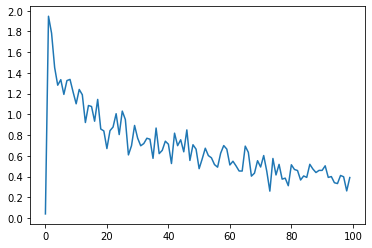

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=5000)


### The graph above shows the variation of NLL LOSS ( Negative Log Likely Loss ) with the number of epochs. 

In [ ]:
#saving the encoder and decoder model
#encoder_save_name = 'encoder.pt'
#path1 = F"/content/gdrive/My Drive/{encoder_save_name}" 
#torch.save(encoder1.state_dict(), path1)
torch.save(encoder1.state_dict(), 'encoder_model.dict')
#decoder_save_name = 'decoder.pt'
#path2 = F"/content/gdrive/My Drive/{decoder_save_name}" 
#torch.save(attn_decoder1.state_dict(), path2)
torch.save(attn_decoder1.state_dict(), 'attn_decoder.dict')

In [ ]:
#loading the encoder and decoder model
encoder_model = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#encoder_save_name = 'encoder.pt'
#path = F"/content/gdrive/My Drive/{encoder_save_name}"
#encoder.load_state_dict(torch.load(path))

#decoder_save_name = 'decoder.pt'
#path = F"/content/gdrive/My Drive/{decoder_save_name}"
#decoder.load_state_dict(torch.load(path))

encoder_model.load_state_dict(torch.load('encoder_model.dict'))
attn_decoder.load_state_dict(torch.load('attn_decoder.dict'))

<All keys matched successfully>

In [ ]:
evaluateRandomly(encoder_model,attn_decoder)

> free delivery guarantee shipping ishoes replacement cash kellod7 kello products loafers flipkartcom genuine
= footwear
<__main__.Lang object at 0x7f4f1897f590> free delivery guarantee shipping ishoes replacement cash kellod7 kello products loafers flipkartcom genuine
< footwear <EOS>

> huge orange collection shop nitlon india branded clothes online mens tshirt apparels neck round solid henley flipkartcom
= clothing
<__main__.Lang object at 0x7f4f1897f590> huge orange collection shop nitlon india branded clothes online mens tshirt apparels neck round solid henley flipkartcom
< clothing <EOS>

> free delivery shipping white veelys ideal roller online skates cash boys size products shiny flipkartcom quad genuine
= sports & fitness
<__main__.Lang object at 0x7f4f1897f590> free delivery shipping white veelys ideal roller online skates cash boys size products shiny flipkartcom quad genuine
< bags, wallets & belts <EOS>

> shipping free guarantee delivery prices rs449 cash replacement show

<__main__.Lang object at 0x7f4f1897f590> type altht3p21 wash additional care general solid contents gentle cotton package pattern style shorts navyspecifications navy sales ideal machine code cycling water features pack alisha fabric details bleach number lycra lukewarm womens


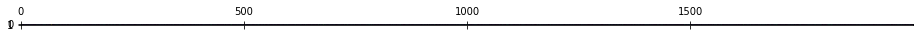

In [ ]:
output_words, attentions = evaluate(encoder_model,attn_decoder, "type altht3p21 wash additional care general solid contents gentle cotton package pattern style shorts navyspecifications navy sales ideal machine code cycling water features pack alisha fabric details bleach number lycra lukewarm womens")
plt.matshow(attentions.numpy())
#plt.show()

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    out=' '.join(output_words).rstrip(' <EOS>')
    print('output =', out )
    return out
    #showAttention(input_sentence, output_words, attentions)


In [ ]:
evaluateAndShowAttention("blue depth compartments closure medium ideal girls body occasion code style weight material height pockets color dimensions blue features closure formal type size zipspecifications material general denim width shoulder number")

<__main__.Lang object at 0x7f4f1897f590> blue depth compartments closure medium ideal girls body occasion code style weight material height pockets color dimensions blue features closure formal type size zipspecifications material general denim width shoulder number
input = blue depth compartments closure medium ideal girls body occasion code style weight material height pockets color dimensions blue features closure formal type size zipspecifications material general denim width shoulder number
output = bags, wallets & belts


'bags, wallets & belts'

In [ ]:
categories = np.unique(maindf['category'].to_list())
categories

array(['automotive', 'baby care', 'bags, wallets & belts',
       'beauty and personal care', 'cameras & accessories', 'clothing',
       'computers', 'ebooks', 'eyewear', 'footwear', 'furniture',
       'gaming', 'health & personal care appliances', 'home & kitchen',
       'home decor & festive needs', 'home entertainment',
       'home furnishing', 'home improvement', 'jewellery',
       'kitchen & dining', 'mobiles & accessories', 'others',
       'pens & stationery', 'pet supplies', 'sports & fitness',
       'sunglasses', 'tools & hardware', 'toys & school supplies',
       'watches'], dtype='<U33')

In [ ]:
cat_ind = np.arange(0,len(categories))
cat_ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [ ]:
category_dictionary = dict(zip(categories,cat_ind))
category_dictionary

{'automotive': 0,
 'baby care': 1,
 'bags, wallets & belts': 2,
 'beauty and personal care': 3,
 'cameras & accessories': 4,
 'clothing': 5,
 'computers': 6,
 'ebooks': 7,
 'eyewear': 8,
 'footwear': 9,
 'furniture': 10,
 'gaming': 11,
 'health & personal care appliances': 12,
 'home & kitchen': 13,
 'home decor & festive needs': 14,
 'home entertainment': 15,
 'home furnishing': 16,
 'home improvement': 17,
 'jewellery': 18,
 'kitchen & dining': 19,
 'mobiles & accessories': 20,
 'others': 21,
 'pens & stationery': 22,
 'pet supplies': 23,
 'sports & fitness': 24,
 'sunglasses': 25,
 'tools & hardware': 26,
 'toys & school supplies': 27,
 'watches': 28}

In [ ]:
pred_test=pd.DataFrame()
pred_test['y_actual'] = test['category'].apply(lambda x: category_dictionary[x])
pred_test.head()

y_actual
5048         18
1263          2
19010         5
7213         27
976          19

In [ ]:
pred_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 5048 to 15796
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   y_actual  4000 non-null   int64
dtypes: int64(1)
memory usage: 222.5 KB


In [ ]:
test['prediected'] = test['description'].apply(lambda x: evaluateAndShowAttention(x))

Streaming output truncated to the last 5000 lines.
input = home however quality signifies terms specially compilation give handcrafted divine assortment gold color allure dimensions richest islam high handicrafts work leaf fine business condition spiritual variation element plated hometemple showpiece condition ambiance metal products note piece home quality pick complements price image aura reverberate traditional venture shown madina slight would spiritual religious office brass compromise take designed home details this hometemple rich bring embellishment spritual interiors handmade india gold individuality note there design could ethnicity spirituality ethnic spiritual ratashcom place carving la01262 harmonize skill weight home
output = home decor & festive needs
<__main__.Lang object at 0x7f4f1897f590> antislip sizes class quality apple robust cover designed price superior ways puppy brings mobile back lost protects matte ipad special elegance finish multicolor sturdiness covers t

In [ ]:
test.head()

product_name  ...              prediected
5048                               voylla alloy necklace  ...               jewellery
1263                                 x-well shoulder bag  ...   bags, wallets & belts
19010  romano checkered single breasted formal men's ...  ...                clothing
7213   neo gold leaf fancy school art plastic pencil box  ...  toys & school supplies
976                    akup without-the-rain ceramic mug  ...        kitchen & dining

[5 rows x 4 columns]

In [ ]:
test["T/F"] = test['prediected'].apply(lambda x: 1 if x in category_dictionary else 0)

In [ ]:
test.head()

product_name  ... T/F
5048                               voylla alloy necklace  ...   1
1263                                 x-well shoulder bag  ...   1
19010  romano checkered single breasted formal men's ...  ...   1
7213   neo gold leaf fancy school art plastic pencil box  ...   1
976                    akup without-the-rain ceramic mug  ...   1

[5 rows x 5 columns]

In [ ]:
test.loc[(test['T/F']==0)]

product_name  ... T/F
11739           vitalwalls without frame canvas painting  ...   0
16611                     i square enterprises solar kit  ...   0
374    eshoppee laughing buddha for success and wealt...  ...   0
7716   silver kartz beach sky blue wayfarer, rectangu...  ...   0
3052   quoface day and night vision car and bike driv...  ...   0

[5 rows x 5 columns]

Here we saw that there are a few rows that do not have the complete category preicted. Sor now, we have randomly matched a category using string matching. 

Note** that the alternative method will be to add the matching while training the model itself

In [ ]:
#import re
def find_cat(cat):
  for c in category_dictionary:
    if(cat in c):
      return c

test['predicted'] = test['prediected'].apply(lambda x: x if x in category_dictionary else find_cat(x))

In [ ]:
test.loc[(test['T/F']==0)]

product_name  ...               predicted
11739           vitalwalls without frame canvas painting  ...          home & kitchen
16611                     i square enterprises solar kit  ...  toys & school supplies
374    eshoppee laughing buddha for success and wealt...  ...          home & kitchen
7716   silver kartz beach sky blue wayfarer, rectangu...  ...  toys & school supplies
3052   quoface day and night vision car and bike driv...  ...   bags, wallets & belts

[5 rows x 6 columns]

In [ ]:
pred_test.head()

y_actual
5048         18
1263          2
19010         5
7213         27
976          19

In [ ]:
pred_test['y_pred'] = test['predicted'].apply(lambda x: category_dictionary[x])

In [ ]:
pred_test.head()

y_actual  y_pred
5048         18      18
1263          2       2
19010         5       5
7213         27      27
976          19      19

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_test['y_actual'], pred_test['y_pred']))

              precision    recall  f1-score   support

           0       0.62      0.91      0.74       190
           1       0.78      0.57      0.66       112
           2       0.23      0.28      0.25        50
           3       0.75      0.66      0.70       143
           4       0.00      0.00      0.00        20
           5       0.92      0.99      0.95      1266
           6       0.40      0.60      0.48       110
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.85      0.96      0.90       234
          10       0.89      0.21      0.33        39
          11       1.00      0.22      0.36         9
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         6
          14       0.75      0.65      0.70       192
          15       0.00      0.00      0.00         5
          16       0.49      0.78      0.60       110
          17       0.50    

**We an see that our model works well with an accuracy of 81%**

To further improve our accuracy, we can add more than 1 attention layers and do cross entropy validation to get the optimal model for this particular technique